In [2]:
pip install micromlgen

  Preparing metadata (setup.py) ... done
  Created wheel for micromlgen: filename=micromlgen-1.1.28-py3-none-any.whl size=32152 sha256=a73cf07298df96d8f49981afebac29337cbeb800b911fe54232411a78758f424
  Stored in directory: /root/.cache/pip/wheels/97/54/64/5d82c310920abe1be0d120313ceb9e12c88f5701f53f6ed248
Successfully built micromlgen


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/My Drive/Trabajo de Grado/Tesis/Pruebas/Multicriterio/Datasets/datos_predichosARBOL.csv")
#data = pd.read_csv("/content/drive/My Drive/Trabajo de Grado/Tesis/Pruebas/Multicriterio/Datasets/datos_simulados_equilibrados_MulticriterioARBOL.csv")
data.head(10)

,Promedio Temperatura,Promedio Humedad,Promedio CO2,Promedio TVCO,Suma,Alerta predicha
0,0.440205,0.168472,0.074892,0.015264,0.698834,Muy Alto
1,0.113952,0.180013,0.135815,0.080880,0.510661,Alto
2,0.366971,0.165835,0.012062,0.067152,0.612020,Alto
3,0.375294,0.131329,0.001785,0.034272,0.542679,Alto
4,0.418682,0.071505,0.088985,0.045456,0.624627,Muy Alto
5,0.412423,0.160093,0.007508,0.098880,0.678903,Muy Alto
6,0.139181,0.072855,0.020554,0.020400,0.252990,Medio
7,0.383324,0.151435,0.101354,0.045888,0.682001,Muy Alto
8,0.031479,0.229062,0.104431,0.095904,0.460876,Alto
9,0.330314,0.059820,0.152985,0.048864,0.591983,Alto


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Promedio Temperatura  10000 non-null  float64
 1   Promedio Humedad      10000 non-null  float64
 2   Promedio CO2          10000 non-null  float64
 3   Promedio TVCO         10000 non-null  float64
 4   Suma                  10000 non-null  float64
 5   Alerta predicha       10000 non-null  object 
dtypes: float64(5), object(1)
memory usage: 468.9+ KB


In [6]:
# Variables predictoras
# X = data.iloc[:,0:5]
X = data.iloc[:,0:4]

# Variable a predecir
Y = data.iloc[:,5]

X.head()

,Promedio Temperatura,Promedio Humedad,Promedio CO2,Promedio TVCO
0,0.440205,0.168472,0.074892,0.015264
1,0.113952,0.180013,0.135815,0.080880
2,0.366971,0.165835,0.012062,0.067152
3,0.375294,0.131329,0.001785,0.034272
4,0.418682,0.071505,0.088985,0.045456


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.2, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 399 to 7270
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Promedio Temperatura  2000 non-null   float64
 1   Promedio Humedad      2000 non-null   float64
 2   Promedio CO2          2000 non-null   float64
 3   Promedio TVCO         2000 non-null   float64
dtypes: float64(4)
memory usage: 78.1 KB


In [8]:
from sklearn.preprocessing import LabelEncoder
# Convertir etiquetas de clase a valores numéricos
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)
Y_train_encoded

array([3, 3, 0, ..., 2, 0, 0])

In [9]:
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from micromlgen import port

arbol = xgb.XGBClassifier(max_depth=2, n_estimators=50)

arbol_varroa = arbol.fit(X_train, Y_train_encoded)

# Imprimir el código C++ para microcontroladores
print(port(arbol_varroa))

#pragma once
#include <cstdarg>
namespace Eloquent {
    namespace ML {
        namespace Port {
            class XGBClassifier {
                public:
                    /**
                    * Predict class for features vector
                    */
                    int predict(float *x) {
                        float votes[4] = { 0.0f };
                        // tree #1
                        if (x[0] <= 0.07371934) {
                            if (x[2] <= 0.10116923) {
                                votes[0] += -0.16849315;
                            }

                            else {
                                votes[0] += 0.15050168;
                            }
                        }

                        else {
                            if (x[0] <= 0.37726647) {
                                votes[0] += 0.32045457;
                            }

                            else {
                                votes[0] += 0.024902115;
        

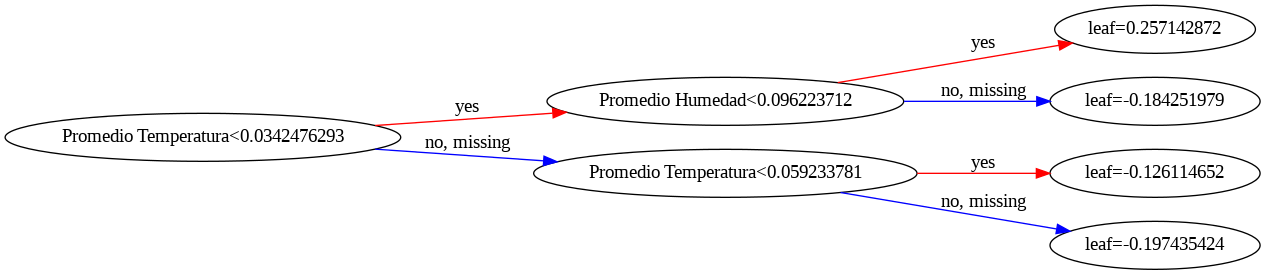

In [10]:
import graphviz
from xgboost import to_graphviz

# Obtener el árbol enésimo del modelo (ajusta n para seleccionar un árbol específico)
n = 1
arbol = to_graphviz(arbol_varroa, num_trees=n, rankdir='LR')

# Guardar el gráfico como un archivo PNG
archivo_grafico = '/content/arbol_xgboost'
arbol.render(archivo_grafico, format='png', cleanup=True)

# Mostrar el gráfico en el entorno de Colab
from IPython.display import Image
Image(filename=f'{archivo_grafico}.png')


In [11]:
Y_pred_encoded = arbol_varroa.predict(X_test)

Y_pred = label_encoder.inverse_transform(Y_pred_encoded)

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
matriz = confusion_matrix(Y_test, Y_pred)
matriz

array([[3693,    0,   83,   83],
       [   0,   80,  103,    0],
       [ 256,   11, 1686,    0],
       [ 148,    0,    0, 1857]])

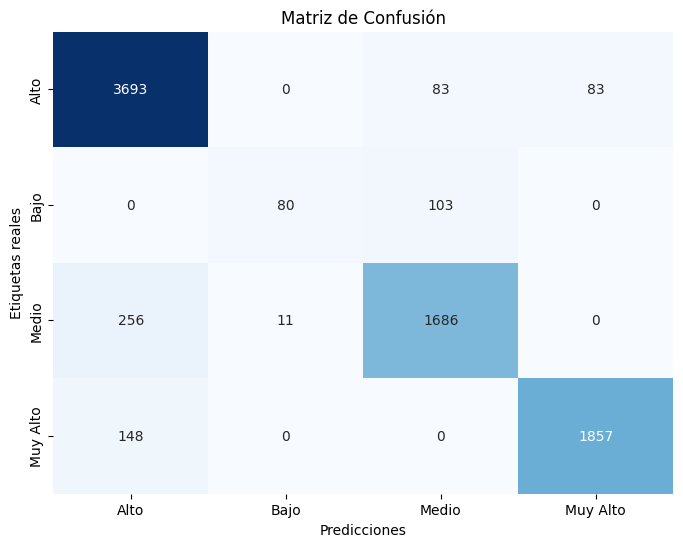

In [13]:
# Etiquetas de las clases
class_names = ['Alto', 'Bajo', 'Medio', 'Muy Alto']

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicciones')
plt.ylabel('Etiquetas reales')
plt.title('Matriz de Confusión')
plt.show()

In [14]:
# Calcular la exactitud (Accuracy)
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Exactitud (Accuracy): {accuracy}")

# Reporte de Clasificación (precision, recall, f1-score)
reporte_clasificacion = classification_report(Y_test, Y_pred)
print("Reporte de Clasificación:")
print(reporte_clasificacion)

matriz

Exactitud (Accuracy): 0.9145
Reporte de Clasificación:
              precision    recall  f1-score   support

        Alto       0.90      0.96      0.93      3859
        Bajo       0.88      0.44      0.58       183
       Medio       0.90      0.86      0.88      1953
    Muy Alto       0.96      0.93      0.94      2005

    accuracy                           0.91      8000
   macro avg       0.91      0.80      0.83      8000
weighted avg       0.91      0.91      0.91      8000



array([[3693,    0,   83,   83],
       [   0,   80,  103,    0],
       [ 256,   11, 1686,    0],
       [ 148,    0,    0, 1857]])

In [15]:
import joblib

# Guardar el modelo entrenado en un archivo
#filename = '/content/drive/My Drive/Trabajo de Grado/Tesis/Pruebas/Multicriterio/arbol_modelo.tflite'
#joblib.dump(arbol_varroa, filename)

# Luego, puedes cargar el modelo en otro momento usando:
# arbol_cargado = joblib.load(filename)


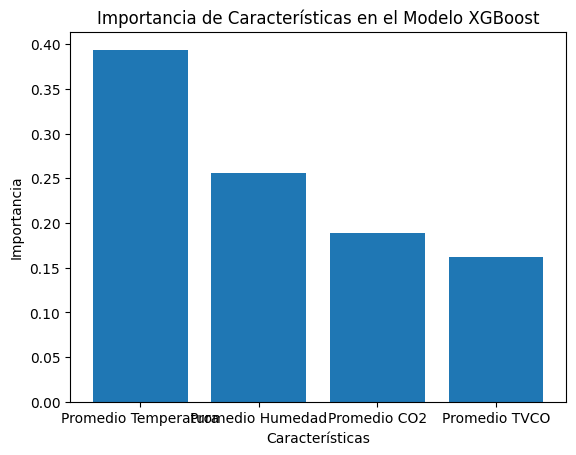

In [16]:
# Obtener la importancia de las características
importancias_caracteristicas = arbol_varroa.feature_importances_

# Crear un gráfico de barras para mostrar la importancia de las características
plt.bar(range(len(importancias_caracteristicas)), importancias_caracteristicas, tick_label=X.columns)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de Características en el Modelo XGBoost')
plt.show()

In [17]:
!apt-get install -y graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


<Figure size 2000x1000 with 0 Axes>

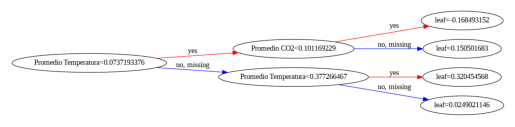

In [18]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

# Assuming you want to plot the first tree in the model
plt.figure(figsize=(20, 10))
plot_tree(arbol_varroa, num_trees=0, rankdir='LR')  # Adjust num_trees as needed
plt.show()